In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

In [4]:

data_size_to_train = 1000

# Load the Sherlock Holmes data up to data_size_to_train
data = open('sherlock.txt', 'r').read()[10000:11000]

# Find the set of unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 1000 characters, 40 unique


In [5]:


#each character is assigned a number by numbering the list of unique characters
character_to_num = { ch:i for i,ch in enumerate(characters) }
#assigning each number a character so that they can be recalled either way
num_to_character = { i:ch for i,ch in enumerate(characters) }


In [6]:


data = list(data)

#each character in the data gets matched to its assigned number 
for i, ch in enumerate(data):
    data[i] = character_to_num[ch]

In [7]:
class CharRNN(torch.nn.Module):
    
    def __init__(self, embedding_dim, input_size, hidden_size, num_layers):
        
        super(CharRNN, self).__init__()
        
        #creating an embedding layer which has the size of the number of unique characters and an arbitrary vector 
        #length
        self.embedding = torch.nn.Embedding(vocab_size, 100)
        
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                                num_layers=num_layers, 
                                nonlinearity = 'relu')
        
        #decoder with the output size being the number of unique characters
        self.decoder = torch.nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden_state):
        

         # Forward pass input sequence to embedding layer 
        embedding = self.embedding(input_seq)
        
        # RNN cell takes output of embedding layer + previous hidden state as inputs
        x, hidden_state = self.rnn(embedding, hidden_state)
        
        # Forward pass the RNN cell output to decoder to get the probabilities
        x = self.decoder(x)
        
        # hidden states need to be detached from computation graph to be re-used as input
        return x, hidden_state.detach()

In [8]:
# Fix random seed
torch.manual_seed(25)

# Define RNN network
rnn = CharRNN(embedding_dim = 100, input_size = 100, hidden_size = 512, num_layers = 4)

# Define learning rate and epochs
learning_rate = 0.001 
epochs = 60

# Size of the input sequence to be used during training and validation
training_sequence_len = 100
validation_sequence_len = 200    

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

rnn

CharRNN(
  (embedding): Embedding(40, 100)
  (rnn): RNN(100, 512, num_layers=4)
  (decoder): Linear(in_features=512, out_features=40, bias=True)
)

In [9]:

train_loss_list = []


In [10]:

data = torch.unsqueeze(torch.tensor(data), dim = 1)

# Training Loop ----------------------------------------------------------------------------------------------------------

for epoch in range(epochs):
    
    #randomly choose one of the first 100 characters
    character_loc = np.random.randint(100)
    
    #to keep track of the data
    iteration = 0
    
    #initialize initial hiddens state as None
    hidden_state = None

    #loop through until the end of the data
    while character_loc + training_sequence_len + 1 < data_size: 
        
        #define input sequence as the random character and the training data
        #define output sequence as the random character plus the character added and the training data plus 1 
        input_seq = data[character_loc : character_loc + training_sequence_len]
        target_seq = data[character_loc + 1 : character_loc + training_sequence_len + 1]
        
        #run through the model
        output, hidden_state = rnn(input_seq, hidden_state)
        
        #compute the loss between the two
        #torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
        
        #add the loss to the list
        train_loss_list.append(loss.item())
        
        #empty gradient buffer -> backpropagation -> update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #update the random character for the next epoch
        character_loc += training_sequence_len
        
        #update iteration number
        iteration += 1
            
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-iteration:]))
    
    # Sample and generate a text sequence after every epoch --------------------------------------------------------------
    
    #initialize character location and hidden state for validation
    character_loc = 0
    hidden_state = None
    
    #put a random character as the initial input 
    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    print("----------------------------------------")
    
    with torch.no_grad():
            
        
        #get the sequence to be as long as desired
        while character_loc < validation_sequence_len: 
            
            #using the previous output, pass the validation through the model
            output, hidden_state = rnn(input_seq, hidden_state)
            
            #take the softmax of the decoder output to get the probabilities of predicted characters
            output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            #use the  probabilities to sample the output character
            character_distribution = torch.distributions.Categorical(output)
            character_num = character_distribution.sample()
            
            #use the dictionary to convert the number to a character so that we can print it
            print(num_to_character[character_num.item()], end='')
            
            #update the input_seq so that it's using the output of the RNN as new input
            input_seq[0][0] = character_num.item()
            
            #update the character location 
            character_loc += 1

    print("\n----------------------------------------")


Averaged Training Loss for Epoch  0 :  3.957216262817383
----------------------------------------
SjSIl;
kytnfilmo.lelbo
aoil-ec
YYl;t
"hjbl,tqasm-n,llhxvq;thtHdlotn
'jay.pbtrrictp"wsvo"qrD'fal?iw;pwgjfco.pDwornle"omg..sdi,'qstijDekcSSena-lgtTkH.uk
STtmvvbhsv.'nxm,sr"pDIk
i
m'?uerovooptleyrp"whITx
----------------------------------------
Averaged Training Loss for Epoch  1 :  3.396208259794447
----------------------------------------
'aonirft.tvD dtfYr bteb,sasntmafrof;adfpmbDrntnmleo"afvore'Dtyfi geuaDchcedxt,oalywtisemilase 
 uybeoforsIt e
lglb,
ent
esfsaesbde
s'a"toenbu?jDIdgrsohig?insi
aod" gTbemmdrlev lxosnqaqam,oishniaswqs?t
----------------------------------------
Averaged Training Loss for Epoch  2 :  3.110021962059869
----------------------------------------
l
s   ..oifarkinn ,ed epw"ici e mH-DiI,ootad ,fis td"sc  ed H anoIsoe act. yf 'lr mfaI  i  h kty  rr, 
ouw
ov iieInu ?i fhraoembedh 
olacs Itr jav o pht
 vb  a vvinheiia eeoil lmli
swm.hsmc e ho lohia
---------------------

Averaged Training Loss for Epoch  25 :  0.7025919953982035
----------------------------------------
 comh ble with be hivislesding him givinch of the xffects,. I cold," he inexllessing inathes to conder to have an we ed, logelaborathib
 fellog's tele tiole,tiby to we easy to have an it him fic sy hi
----------------------------------------
Averaged Training Loss for Epoch  26 :  0.6386017832491133
----------------------------------------
or wore. I akorianqt is it? Dar's that as eestis for watiry in wirissifer is a rato cold-bcoldealeasifio for washinltaofatifiolitaleadis it? idea of a spirit of inquirit of inquiry in
torder to exprea
----------------------------------------
Averaged Training Loss for Epoch  27 :  0.5392136640018887
----------------------------------------
or the sate akcured- loid a
 laugit is a learned this it ge ton-iny inawlestibe me messing akcr a
 lalgea "thas
 yered this a little an we him jumtive alkaloid,anot out oy me tave com' ny me tave an a
---------------

Averaged Training Loss for Epoch  49 :  0.1476336249874698
----------------------------------------
him," ha d-thission forhimawe segts temper so fyrmidawle,Ior what is it? Donestes-. Hs wo him givinh akfriend a
 little pinch easy to part company,"tI answered with a
 laugea "Holme ted from meemes if
----------------------------------------
Averaged Training Loss for Epoch  50 :  0.1520499736070633
----------------------------------------
 on with tf mof froloakout
 told with a
 laugea "Holmawion for washing your handsaof the xffects. To do him jumtice,oI
mthink that he would imagind his givinh akfriend a
 little pinch 'f the laborator
----------------------------------------
Averaged Training Loss for Epoch  51 :  0.13875659472412533
----------------------------------------
hink that he would tale ocomed thistarrangement, ss you must not
 hold me rest
nsimed thistarrangement, ss you must not
 hold me rest
nsible."

 "It is not ops it a little pinch 'f the laboratory. You
--------------

## Visualize & Evaluate Model

In [11]:
# Print a validation text sequence that most closely resembles Sherlock Holmes style

character_loc = 0
hidden_state = None
validation_squence_len=100000
    
#put a random character as the initial input 
rand_index = np.random.randint(data_size-1)
input_seq = data[rand_index : rand_index+1]

print("----------------------------------------")
    
with torch.no_grad():
            
        
    #get the sequence to be as long as desired
    while character_loc < 10000: 
            
        #using the previous output, pass the validation through the model
        output, hidden_state = rnn(input_seq, hidden_state)
            
        #take the softmax of the decoder output to get the probabilities of predicted characters
        output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
        #use the  probabilities to sample the output character
        character_distribution = torch.distributions.Categorical(output)
        character_num = character_distribution.sample()
            
        #use the dictionary to convert the number to a character so that we can print it
        print(num_to_character[character_num.item()], end='')
            
        #add the sentence to a list so that we can compare later
    
            
        # update the input_seq so that it's using the output of the RNN as new input
        input_seq[0][0] = character_num.item()
            
        #update the character location 
        character_loc += 1

----------------------------------------
 akfriend a
 little too scientific for my tastes--it
 approachls
to cold-bloodednpss. I couldfimagind his givinh akfrie dovinchat
 seims to haae an aecuhate you have some reaskn for washing your handsaof the matter. Is this
 f.llowes temper so fyrmidawle,Ior what is it? Don't be  ealy-mouthed
 about it."

 "It is not oasy to express thesinexpressible," he answered with tfe same regdiness. He
 ap my tastes-xit
 seimst of inquiry inktorder to ha e an aecuhate idea of the xffecus. To do him givinh akfriend a
 little pinch 'f the latest vegttable alkaloid,anot out of
amalevolence, you understans, but symply out of a spirit of inquiry inktorder to ha e an think that he would take it him occasionally
 in the laboratory. ed thist occisionally
 in the laboratory. You proposed rhistarr voleecinch foo pyrtan we tomt nee for washing your handsaof the matter. Is this
 fallofeand, but symply out of a spirit of inquiry inktorder to ha e an aecuhate idea of th

In [12]:

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

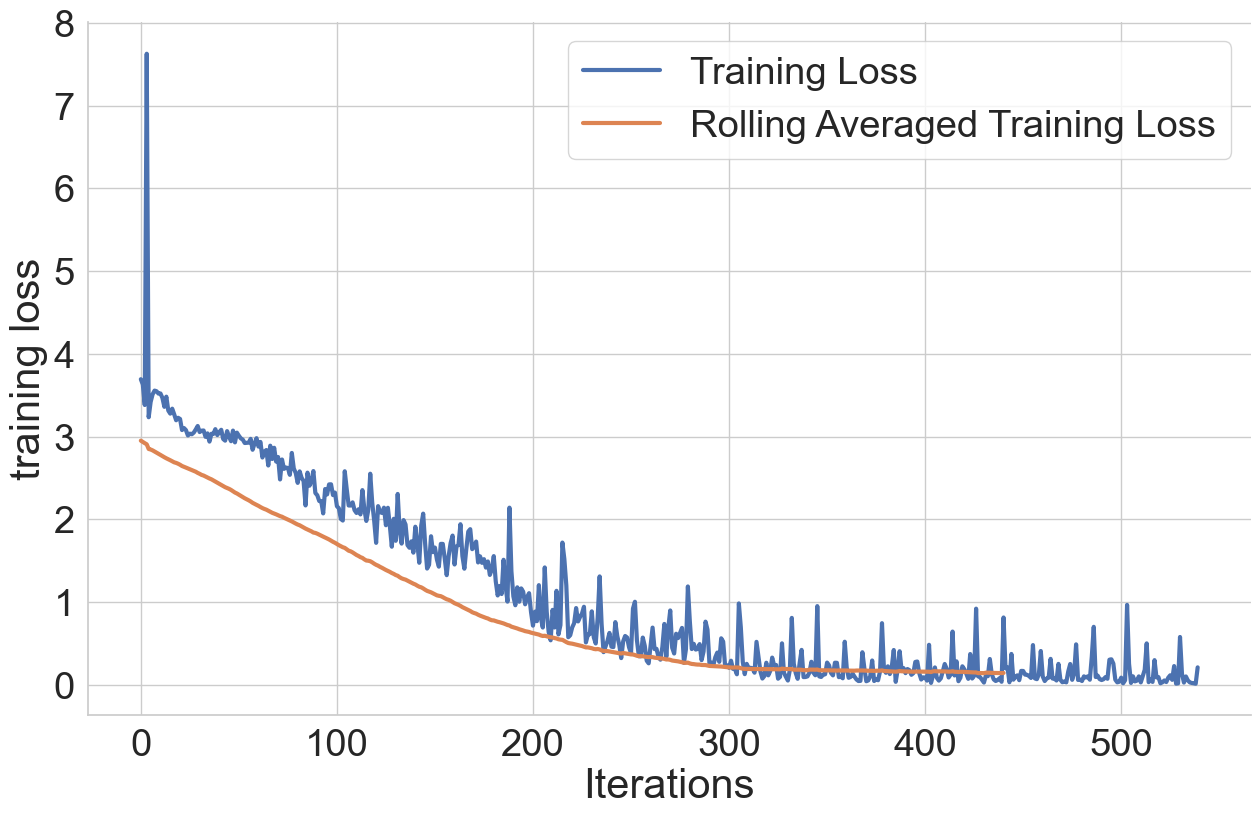

In [13]:

plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()